In [2]:
sandbox = 'farg'
PATH_DATA = '/data/sandboxes/'+sandbox+'/data/all_data/'



# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Información sobre los datos

* Encounter ID 
    - ID único de la admisión de un paciente
* Patient number 
    - ID único de paciente
* Race 
    - Raza
* Gender
    - Sexo
* Age
    - Edad (en intervalos de 10 años)
    
* Weight
    - Peso en libras
* Admission type 
    - Identificador del tipo de admisión 
* Discharge disposition
    - Identificador del tipo de alta 
* Admission source
    - Identificador de la fuente de admisión 
* Time in hospital 
    - Número de días que han pasado entre admission y discharge (admisión y alta)
* Payer code
    - Identificador del código de pago
* Medical specialty
    - Identificador de la especialidad médica donde es ingresado el paciente
* Number of lab procedures 
    - Número de análisis en laboratorio que se han llevado a cabo durante el ingreso del paciente
* Number of procedures 
    - Número de procedimientos (diferentes a los análisis en laboratorio) que se han llevado a cabo durante el ingreso del paciente
* Number of medications
    - Número de nombres de medicamentos distintos que se hayan administrado al paciente durante su ingreso
* Number of outpatient visits
    - Número de visitas como paciente externo (no ingresado, por ejemplo) que ha tenido el paciente durante el año antes de esta admisión
* Number of emergency
    - Numero de visitas de emergencia del paciente durante el año antes de esta admisión
* Number of inpatient visits 
    - Número de visitas en las que ha estado ingresado el paciente durante el año antes de esta admisión
* Diagnosis 1 
    - Diagnóstico primario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 2 
    - Diagnóstico secundario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 3 
    - Diagnóstico adicional (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Number of diagnoses 
    - Número de diagnósticos que se han introducido al sistema
* Glucose serum test result 
    - Indica el rango del resultado de la prueba de glucosa, o si no se llevó a cabo la prueba. Valores: “>200,” “>300,” “normal,” y “none” si no se realizó la prueba
* A1c test result
    - Indica el rango del resultado de la prueba de hemoglobina A1c, o si no se llevó a cabo la prueba. Valores: “>8” si el resultado fue mayor del 8%, “>7” si el resultado fue mayor del 7% pero menor del 8%, “normal” si el resultado fue menor del 7%, y “none” si no se realizó la prueba.
* Change of medications 
    - Indica si ha habido un cambio en la medicación para la diabetes (tanto en la dosis como en el propio medicamento)
* Diabetes medications 
    - Indica si ha el paciente toma medicación para la diabetes
* 24 features for medications
    - Para los nombres genéricos de los medicamentos metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiridepioglitazone, metformin-rosiglitazone, y metforminpioglitazone, la variable indica si se prescribió o no el medicamento durante la visita del paciente
    - Valores: “up” si se subió la dosis durante la visita, “down” si se bajó la dosis, “steady” si la dosis no cambió, y “no” si no se prescribió el medicamento
* Readmitted 
    - Indica cuántos días ha tardado el paciente en volver al hospital y ser readmitido. Valores: “<30” si el paciente fue readmitido en menos de 30 días, “>30” si el paciente fue readmitido en más de 30 días, y “No” si el paciente no ha sido readmitido



## Cargar librerías

In [3]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans

Matplotlib is building the font cache; this may take a moment.
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.




## Lectura de datos

In [7]:
# Obtenemos los datos de cada uno de los data sets

diabetes = pd.read_csv('diabetic_data.csv', sep=',')
admission_source = pd.read_csv('admission_source_id.csv', sep=',')
admission_type = pd.read_csv('admission_type_id.csv', sep=',')
discharge_disposition = pd.read_csv('discharge_disposition_id.csv', sep=',')

In [8]:
# Cambiamos el nombre a la columna 'description' por 'type_description'

admission_type = admission_type.rename(columns={'description':'type_description'})

In [9]:
# Cambiamos el nombre a la columna 'description' por 'source_description'

admission_source = admission_source.rename(columns={'description':'source_description'})

In [10]:
# Cambiamos el nombre a la columna 'description' por 'disposition_description'

discharge_disposition = discharge_disposition.rename(columns={'description':'disposition_description'})



### comprobar correcta lectura de los datos

In [11]:
# Comprobamos que los datos se leen correctamente para cada uno de los data sets:

diabetes.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1.0,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3.0,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2.0,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2.0,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1.0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [12]:
admission_type.head()

,admission_type_id,type_description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [13]:
admission_source.head()

,admission_source_id,source_description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [14]:
discharge_disposition.head()

,discharge_disposition_id,disposition_description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution


In [15]:
# Todos se leen correctamente

In [16]:
# Tabla dinámica para comprobar correcta lectura de datos

table = pd.pivot_table(diabetes, values='encounter_id', index=['gender', 'race'], columns=['readmitted'], aggfunc=np.count_nonzero)
table

readmitted                          <30     >30      NO
gender          race                                   
Female          ?                40.0    97.0    337.0 
                AfricanAmerican  523.0   1502.0  2318.0
                Asian            6.0     25.0    43.0  
                Caucasian        1436.0  4057.0  6864.0
                Hispanic         47.0    165.0   191.0 
                Other            24.0    59.0    122.0 
Male            ?                41.0    102.0   315.0 
                AfricanAmerican  343.0   919.0   1514.0
                Asian            11.0    21.0    60.0  
                Caucasian        1262.0  3715.0  6535.0
                Hispanic         40.0    135.0   169.0 
                Other            15.0    49.0    139.0 
Unknown/Invalid Other           NaN     NaN      1.0



### juntar todos los datos en el mismo DataFrame

In [17]:
# Juntamos los dataframes

df = pd.merge(diabetes, admission_type, on=['admission_type_id'], how='left')
df = pd.merge(df, admission_source, on=['admission_source_id'], how='left')
df = pd.merge(df, discharge_disposition, on=['discharge_disposition_id'], how='left')


In [18]:
# Muestra el nuevo data frame unido

df[['encounter_id', 'admission_type_id', 'type_description', 'admission_source_id', 'source_description', 
    'discharge_disposition_id', 'disposition_description']].head()


,encounter_id,admission_type_id,type_description,admission_source_id,source_description,discharge_disposition_id,disposition_description
0,2278392,6,None,1,Physician Referral,25,Not Mapped
1,149190,1,Emergency,7,Emergency Room,1,Discharged to home
2,64410,1,Emergency,7,Emergency Room,1,Discharged to home
3,500364,1,Emergency,7,Emergency Room,1,Discharged to home
4,16680,1,Emergency,7,Emergency Room,1,Discharged to home




### estudiar las dimensiones del dataset

In [19]:
d=df.ndim
s=df.size
f=df.shape

print(' Dimensión: ' , str(d), '\n Tamaño: ', str(s),  '\n Rango de readmisión: ' + str(f))

# Contamos con 33.243 entradas de pacientes y 53 variables distintas

 Dimensión:  2 
 Tamaño:  1761879 
 Rango de readmisión: (33243, 53)




## Data Wrangling



### cambiar los nombres de las columnas para que cumplan buenas prácticas

In [20]:
# Cambiamos los nombres de los que tienen guión por guión bajo, y A1cresult por cresult_a1

df.rename(columns= {'A1Cresult' : 'cresult_a1', 'glyburide-metformin' : 'glyburide_metformin','glipizide-metformin' : 'glipizide_metformin', 
                    'glimepiride-pioglitazone' : 'glimepiride_pioglitazone', 'metformin-rosiglitazone' : 'metformin_rosiglitazone',
                    'metformin-pioglitazone' : 'metformin_pioglitazone'}, inplace=True)


In [21]:
# Comprobamos que se ha llevado a cabo el cambio satisfactoriamente

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted,type_description,source_description,disposition_description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1.0,...,No,No,No,No,No,No,NO,None,Physician Referral,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3.0,...,No,No,No,No,Ch,Yes,>30,Emergency,Emergency Room,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2.0,...,No,No,No,No,No,Yes,NO,Emergency,Emergency Room,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2.0,...,No,No,No,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1.0,...,No,No,No,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home




### estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [22]:
# Para ver el formato de las variables

df.dtypes


encounter_id                int64  
patient_nbr                 int64  
race                        object 
gender                      object 
age                         object 
weight                      object 
admission_type_id           int64  
discharge_disposition_id    int64  
admission_source_id         int64  
time_in_hospital            float64
payer_code                  object 
medical_specialty           object 
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                      object 
diag_2                      object 
diag_3                      object 
number_diagnoses            float64
max_glu_serum               object 
cresult_a1                  object 
metformin                   object 
repaglinide                 object 
nateglinide                 object 
chlorpropamide              

In [23]:
# Pasamos los valores "?" a "Unknown" y checamos que se han cambiado

df = df.replace("?", "Unknown")

df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted,type_description,source_description,disposition_description
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,6,25,1,1.0,...,No,No,No,No,No,No,NO,None,Physician Referral,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),Unknown,1,1,7,3.0,...,No,No,No,No,Ch,Yes,>30,Emergency,Emergency Room,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,1,1,7,2.0,...,No,No,No,No,No,Yes,NO,Emergency,Emergency Room,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),Unknown,1,1,7,2.0,...,No,No,No,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),Unknown,1,1,7,1.0,...,No,No,No,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33238,105265992,104815368,AfricanAmerican,Male,[40-50),Unknown,1,1,7,5.0,...,No,No,No,No,Ch,Yes,>30,Emergency,Emergency Room,Discharged to home
33239,105266388,107942895,Caucasian,Female,[50-60),Unknown,1,6,7,5.0,...,No,No,No,No,No,No,NO,Emergency,Emergency Room,Discharged/transferred to home with home health service
33240,105267612,25969050,Caucasian,Female,[80-90),Unknown,1,6,17,5.0,...,No,No,No,No,Ch,Yes,>30,Emergency,None,Discharged/transferred to home with home health service
33241,105269910,5331294,AfricanAmerican,Male,[70-80),Unknown,1,1,7,4.0,...,No,No,No,No,Ch,Yes,NO,Emergency,Emergency Room,Discharged to home




### estudiar si hay registros repetidos

In [24]:
# Nos interesan los pacientes que puedan estar duplicados

# Por un lado, la variable 'encounter_id', que es el ID único de la admisión de un paciente, debería ser único para cada caso
# Comprobamos que así sea

df['encounter_id'].duplicated().any() 


False

In [25]:
# Por otro lado, la variable 'patient_nbr', que es el ID único de paciente es único para cada paciente
# Por lo tanto, si un paciente ha sido reingresado, debe estar duplicado, por lo que comprobamos que existan duplicados

df['patient_nbr'].duplicated().value_counts()


False    25103
True     8140 
Name: patient_nbr, dtype: int64

In [26]:
#Valores únicos

l_encounter=len(diabetes['encounter_id'].unique())
l_patient=len(diabetes['patient_nbr'].unique())
l_readmitted=len(diabetes['readmitted'].unique())
print(' Número de ingresos: ' , str(l_encounter), '\n Número de pacientes: ', str(l_patient),  '\n Rango de readmisión: ' + str(l_readmitted))

# Obtenemos 25.103 pacientes con un ID diferente


 Número de ingresos:  33243 
 Número de pacientes:  25103 
 Rango de readmisión: 4




### estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [27]:
# Creamos una función que nos de los valores que toma cada variable

def variables (variable):
    a = df.groupby(by=variable).size()
    print(a, '\n')
    return a

In [28]:
# Aplicamos la función a las variables

variables('race')
variables('gender')
variables('age')
variables('weight')
variables('time_in_hospital')
variables('payer_code')
variables('medical_specialty')
variables('num_lab_procedures')
variables('num_procedures')
variables('num_medications')
variables('number_outpatient')
variables('number_emergency')
variables('number_inpatient')
variables('diag_1')
variables('diag_2')
variables('diag_3')
variables('number_diagnoses')
variables('max_glu_serum')
variables('cresult_a1')
variables('metformin')
variables('repaglinide')
variables('nateglinide')
variables('chlorpropamide')
variables('glimepiride')
variables('acetohexamide')
variables('glipizide')
variables('glyburide')
variables('tolbutamide')
variables('pioglitazone')
variables('rosiglitazone')
variables('acarbose')
variables('miglitol')
variables('troglitazone')
variables('tolazamide')
variables('examide')
variables('citoglipton')
variables('glyburide_metformin')
variables('glipizide_metformin')
variables('glimepiride_pioglitazone')
variables('metformin_rosiglitazone')
variables('metformin_pioglitazone')
variables('change')
variables('diabetesMed')
variables('readmitted')
variables('type_description')
variables('source_description')
variables('disposition_description')


race
AfricanAmerican    7119 
Asian              166  
Caucasian          23869
Hispanic           747  
Other              409  
Unknown            933  
dtype: int64 

gender
Female             17856
Male               15386
Unknown/Invalid    1    
dtype: int64 

age
[0-10)      130 
[10-20)     399 
[20-30)     550 
[30-40)     1455
[40-50)     3535
[50-60)     5966
[60-70)     7097
[70-80)     8831
[80-90)     4592
[90-100)    688 
dtype: int64 

weight
>200         1    
Unknown      32071
[0-25)       37   
[100-125)    194  
[125-150)    51   
[150-175)    9    
[175-200)    1    
[25-50)      37   
[50-75)      332  
[75-100)     510  
dtype: int64 

time_in_hospital
1.0     4243
2.0     5335
3.0     5471
4.0     4545
5.0     3281
6.0     2575
7.0     1982
8.0     1600
9.0     1094
10.0    918 
11.0    704 
12.0    581 
13.0    478 
14.0    435 
dtype: int64 

payer_code
BC         316  
CH         5    
CM         45   
CP         193  
DM         34   
HM         808  
MC   

disposition_description
Admitted as an inpatient to this hospital                                            1    
Discharged to home                                                                   18962
Discharged/transferred to ICF                                                        274  
Discharged/transferred to SNF                                                        3473 
Discharged/transferred to a long term care hospital.                                 35   
Discharged/transferred to another rehab fac including rehab units of a hospital .    255  
Discharged/transferred to another short term hospital                                598  
Discharged/transferred to another type of inpatient care institution                 821  
Discharged/transferred to home under care of Home IV provider                        87   
Discharged/transferred to home with home health service                              3272 
Discharged/transferred within this institution to Medicare approve

In [29]:
# CONCLUSIONES:

# En 'weight', 'payer_code' y 'medical_specialty' hay muchos "Unknown", por lo que quizás sean variables que haya que quitar
# En 'race' son minoría

# Variables con un único valor de "No" y que no aportan nada, por lo que se podrían eliminar:
# examide, citoglipton, glipizide_metformin, glimepiride_pioglitazone, metformin_rosiglitazone

# Variables con casi únicamente un valor:
# acetohexamide, tolbutamide, miglitol, troglitazone, tolazamide

# Variables que se repiten mucho, pero que pueden dar información:
# number_outpatient, number_emergency, repaglinide, nateglimide, chlorpropamide, glimepimide, pioglitazone,rosiglitazone, acarbose

In [ ]:
# OJO:

# Los valores que empiezan por V en las variables diag SÍ son válidas, por lo que deben ser variables tipo object



### estudiar los nulos en el dataset

In [30]:
# Los "?" no los pillaba como nulos. Ahora aparecen como "Unknown"

df.isnull().sum() # Para verlo en total


encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            1
payer_code                  1
medical_specialty           1
num_lab_procedures          1
num_procedures              1
num_medications             1
number_outpatient           1
number_emergency            1
number_inpatient            1
diag_1                      1
diag_2                      1
diag_3                      1
number_diagnoses            1
max_glu_serum               1
cresult_a1                  1
metformin                   1
repaglinide                 1
nateglinide                 1
chlorpropamide              1
glimepiride                 1
acetohexamide               1
glipizide                   1
glyburide                   1
tolbutamide                 1
pioglitazo

In [31]:
# Sustituimos los nulos de las variables tipo float por la media de la serie

mean_time_in_hospital = df['time_in_hospital'].mean()
mean_num_lab_procedures = df['num_lab_procedures'].mean()
mean_num_procedures = df['num_procedures'].mean()
mean_num_medications = df['num_medications'].mean()
mean_number_outpatient = df['number_outpatient'].mean()
mean_number_emergency = df['number_emergency'].mean()
mean_number_inpatient = df['number_inpatient'].mean()
mean_number_diagnoses = df['number_diagnoses'].mean()

df['time_in_hospital'].fillna(mean_time_in_hospital, inplace=True)
df['num_lab_procedures'].fillna(mean_num_lab_procedures, inplace=True)
df['num_procedures'].fillna(mean_num_procedures, inplace=True)
df['num_medications'].fillna(mean_num_medications, inplace=True)
df['number_outpatient'].fillna(mean_number_outpatient, inplace=True)
df['number_emergency'].fillna(mean_number_emergency, inplace=True)
df['number_inpatient'].fillna(mean_number_inpatient, inplace=True)
df['number_diagnoses'].fillna(mean_number_diagnoses, inplace=True)

In [172]:
# Comprobamos que se han modificado los nulos por las medias

df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  1
medical_specialty           1
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      1
diag_2                      1
diag_3                      1
number_diagnoses            0
max_glu_serum               1
cresult_a1                  1
metformin                   1
repaglinide                 1
nateglinide                 1
chlorpropamide              1
glimepiride                 1
acetohexamide               1
glipizide                   1
glyburide                   1
tolbutamide                 1
pioglitazo

In [32]:
# Los nulos de los variables tipo object las sustituimos por el valor "Unknown"

df.fillna("Unknown", inplace=True)

In [33]:
# Comprobamos que efectivamente ya no hay valores nulos

df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
cresult_a1                  0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [34]:
# Ahora tenemos que decidir qué formatos cambiar
# Redondeamos las variables float y las pasamos a enteros
# Asimismo, pasamos las variables ID de enteros a strings

cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

df[cols] = df[cols].round().astype(int)

cols_id = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[cols_id] = df[cols_id].astype(str)

# Comprobamos que se han redondeado los valores con 0 decimales

df[cols]


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,1,41,0,1,0,0,0,1
1,3,59,0,18,0,0,0,9
2,2,11,5,13,2,0,1,6
3,2,44,1,16,0,0,0,7
4,1,51,0,8,0,0,0,5
...,...,...,...,...,...,...,...,...
33238,5,85,1,18,0,0,0,6
33239,5,53,2,27,1,2,4,9
33240,5,17,0,6,0,1,0,4
33241,4,77,0,15,0,0,0,9


In [35]:
# Comprobamos que se hayan cambiado correctamente los tipos de las variables

df.dtypes

encounter_id                object
patient_nbr                 object
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital            int64 
payer_code                  object
medical_specialty           object
num_lab_procedures          int64 
num_procedures              int64 
num_medications             int64 
number_outpatient           int64 
number_emergency            int64 
number_inpatient            int64 
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses            int64 
max_glu_serum               object
cresult_a1                  object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         



### estudiar los outliers

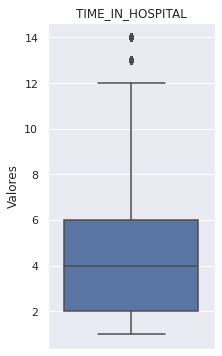

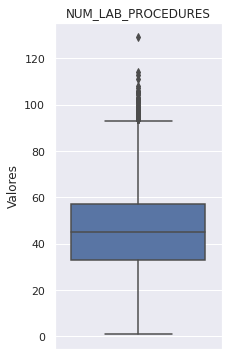

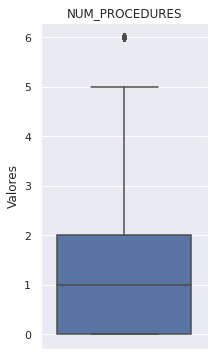

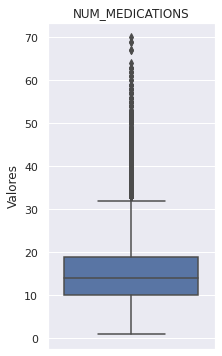

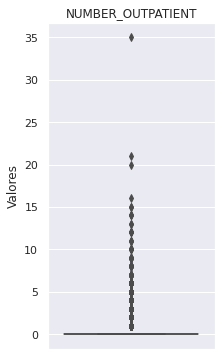

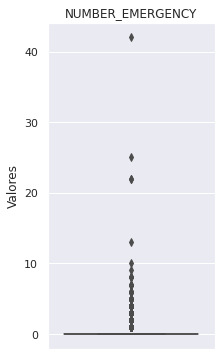

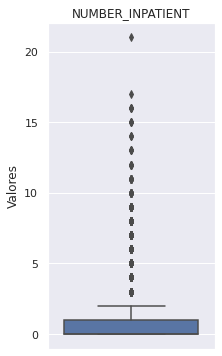

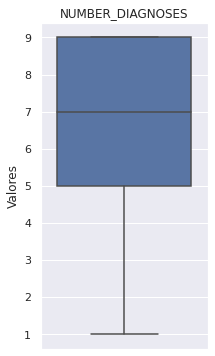

In [36]:
# Obtenemos boxplots para que a primera vista nos enseñe dónde hay outliers (en las variables numéricas)

cols_outliers = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

import matplotlib.pyplot as plt
import seaborn as sns

def diagrama_cajas (variable):
    plt.figure(figsize = (3, 6))
    ax = sns.boxplot(y = df[variable])
    ax.set_title(variable.upper())
    ax.set_ylabel('Valores')

diagrama_cajas(cols_outliers[0])
diagrama_cajas(cols_outliers[1])
diagrama_cajas(cols_outliers[2])
diagrama_cajas(cols_outliers[3])
diagrama_cajas(cols_outliers[4])
diagrama_cajas(cols_outliers[5])
diagrama_cajas(cols_outliers[6])
diagrama_cajas(cols_outliers[7])



In [29]:
# CONCLUSIONES:

# Las variables num_medications, number_outpatient, number_emergency y number_inpatient tienen muchos outliers

# Aplicamos el logaritmo natural para reducir a dichas variables, con el objetivo de reducir la variación que 
# producen los outliers en los datos.

#import math

#outliers = ['num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']

#df[outliers] = np.log(df[outliers])
#df[outliers]

# Finalmente optamos por no aplicar el logaritmo natural, ya que devuelve resultados de infinito y nulos
# No realizamos cambios sobre los outliers, ya que aunque puedan generar algo de distorsión, aportarán información importante

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log


,num_medications,number_outpatient,number_emergency,number_inpatient
0,-inf,NaN,NaN,NaN
1,1.061385,NaN,NaN,NaN
2,0.941939,-0.366513,NaN,-inf
3,1.019781,NaN,NaN,NaN
4,0.732099,NaN,NaN,NaN
...,...,...,...,...
33238,1.061385,NaN,NaN,NaN
33239,1.192660,-inf,-0.366513,0.326634
33240,0.583198,NaN,-inf,NaN
33241,0.996229,NaN,NaN,NaN




### crear variables dummy en caso que sea conveniente

In [37]:
# Dos variables dummy para readmitted: 
# I. readmitted_cat: 0 para no readmitido y 1 en caso positivo; y 
# II. readmitted_cat_d: 0 para <30 y 1 >30; en caso de no ser readmitido usamos valor nulo None, ya que solo identifica a los readmitidos

df['readmitted_cat'] = np.where((df['readmitted'] == '<30') , 1, np.where((df['readmitted'] == '>30'), 1, 0))
df['readmitted_cat_d'] = np.where((df['readmitted'] == '<30') , 0, np.where((df['readmitted'] == '>30'), 1, None))
df[['readmitted', 'readmitted_cat', 'readmitted_cat_d']].head(18)

,readmitted,readmitted_cat,readmitted_cat_d
0,NO,0,None
1,>30,1,1
2,NO,0,None
3,NO,0,None
4,NO,0,None
5,>30,1,1
6,NO,0,None
7,>30,1,1
8,NO,0,None
9,NO,0,None


In [38]:
# Variables dummy para género: 
# gen_cat : 0 female, 1 male

df['gender_cat'] = np.where((df['gender'] == 'Female') , 0, 1)
df[['gender', 'gender_cat']].head(10)

,gender,gender_cat
0,Female,0
1,Female,0
2,Female,0
3,Male,1
4,Male,1
5,Male,1
6,Male,1
7,Male,1
8,Female,0
9,Female,0


In [39]:
# Creamos variables dummies para cada una de las razas

df['race_AfricanAmerican'] = np.where((df['race'] == 'AfricanAmerican') , 1, 0)
df['race_Asian'] = np.where((df['race'] == 'Asian') , 1, 0)
df['race_Caucasian'] = np.where((df['race'] == 'Caucasian') , 1, 0)
df['race_Hispanic'] = np.where((df['race'] == 'Hispanic') , 1, 0)
df['race_Other'] = np.where((df['race'] == 'Other') , 1, 0)
df['race_Unknown'] = np.where((df['race'] == 'Unknown') , 1, 0)




### estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

In [40]:
df.dtypes

# Conclusion: Está todo correcto según descrito en los pasos anteriores

encounter_id      object
patient_nbr       object
race              object
gender            object
age               object
                   ...  
race_Asian        int64 
race_Caucasian    int64 
race_Hispanic     int64 
race_Other        int64 
race_Unknown      int64 
Length: 62, dtype: object



### antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear



# Exploratory Data Analysis



### crear la matriz de correlación

In [41]:
#ANALISIS_DE_VARIABLES_NUMERICAS

# Seleccionamos únicamente aquellas variables que son numéricas, creando un dataframe a partir del cual obtendremos los siguientes puntos

df_numerical = df.select_dtypes(include = ['float64', 'int64'])
df_numerical.head()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_cat,gender_cat,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown
0,1,41,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,3,59,0,18,0,0,0,9,1,0,0,0,1,0,0,0
2,2,11,5,13,2,0,1,6,0,0,1,0,0,0,0,0
3,2,44,1,16,0,0,0,7,0,1,0,0,1,0,0,0
4,1,51,0,8,0,0,0,5,0,1,0,0,1,0,0,0


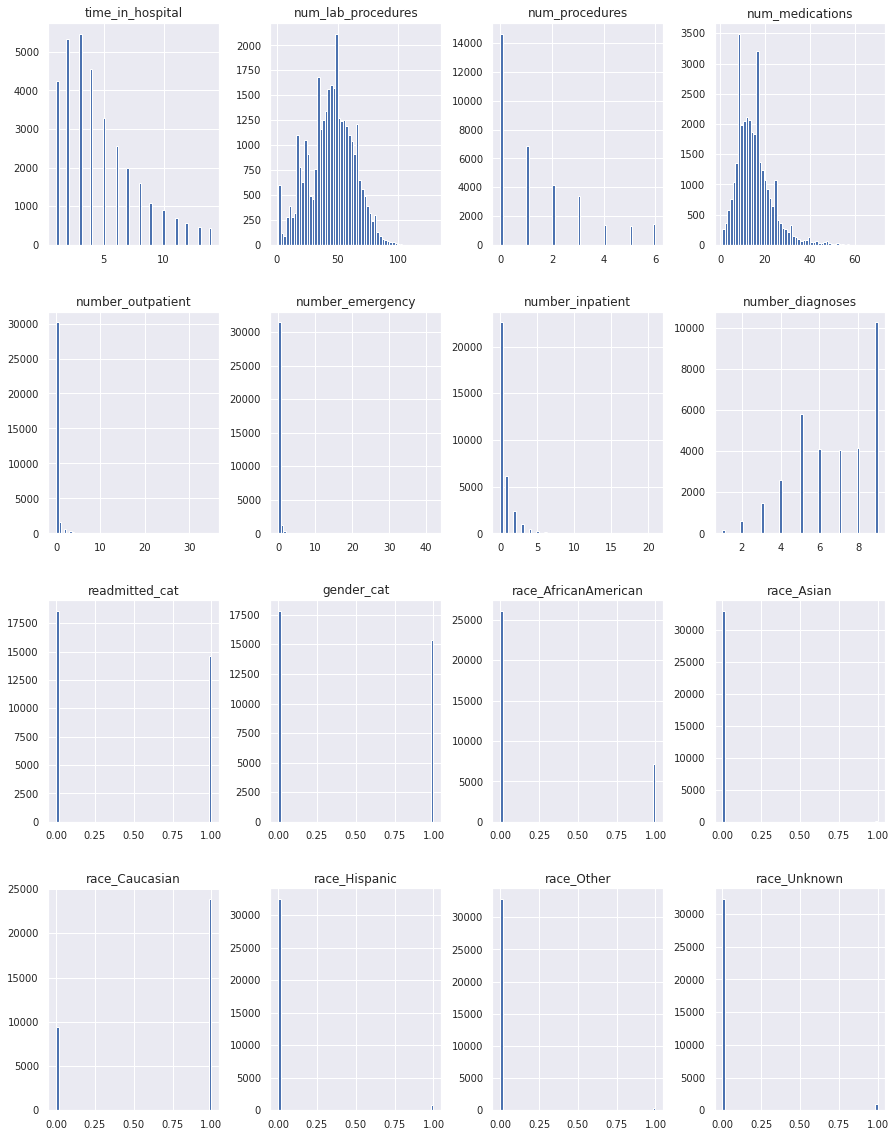

In [42]:
# En un primer lugar, obtenemos los histogramas de las variables numéricas, con el objetivo de estudiar su distribución

df_numerical.hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10);




### pintar la matriz de correlación

In [43]:
# Creamos la matriz de correlación de las variables numéricas

df_numerical.corr()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_cat,gender_cat,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown
time_in_hospital,1.000000,0.310271,0.245185,0.471824,-0.035884,-0.017962,0.081809,0.272854,0.067242,-0.012465,0.009727,-0.012794,0.003192,-0.017808,0.008075,-0.016806
num_lab_procedures,0.310271,1.000000,0.102557,0.189016,-0.116469,-0.083389,0.027635,0.147437,0.074450,-0.006753,0.069076,-0.011579,-0.060379,0.002027,0.010444,-0.010924
num_procedures,0.245185,0.102557,1.000000,0.458320,-0.039864,-0.051730,-0.078095,0.116677,-0.047382,0.072510,-0.064497,-0.005335,0.064870,-0.040143,0.034141,-0.001022
num_medications,0.471824,0.189016,0.458320,1.000000,0.024171,0.008922,0.041013,0.273127,0.044415,-0.001686,-0.075324,-0.026523,0.083530,-0.029550,0.016353,-0.013556
number_outpatient,-0.035884,-0.116469,-0.039864,0.024171,1.000000,0.144816,0.074980,0.079183,0.082080,-0.002648,-0.058672,-0.009779,0.062186,-0.006082,-0.002668,-0.012276
number_emergency,-0.017962,-0.083389,-0.051730,0.008922,0.144816,1.000000,0.192261,0.044850,0.079828,-0.003388,-0.020820,-0.006919,0.029297,0.000314,-0.005261,-0.021921
number_inpatient,0.081809,0.027635,-0.078095,0.041013,0.074980,0.192261,1.000000,0.142818,0.212866,-0.017058,0.044752,-0.008625,-0.021104,0.013797,-0.014792,-0.052487
number_diagnoses,0.272854,0.147437,0.116677,0.273127,0.079183,0.044850,0.142818,1.000000,0.126920,-0.007812,-0.070637,-0.017662,0.108316,-0.030735,-0.007307,-0.079652
readmitted_cat,0.067242,0.074450,-0.047382,0.044415,0.082080,0.079828,0.212866,0.126920,1.000000,-0.014651,0.022619,-0.008662,-0.005043,0.023780,-0.018166,-0.047961
gender_cat,-0.012465,-0.006753,0.072510,-0.001686,-0.002648,-0.003388,-0.017058,-0.007812,-0.014651,1.000000,-0.076345,0.012979,0.062197,-0.000716,0.008039,0.009916


In [44]:
# En este caso, estudiamos más detalladamente las correlaciones de la variable 'time_in_hospital' respecto al resto de variables numéricas
# Debido a que nos parece una variable clave en el data set 

df_numerical_corr = df_numerical.corr()['time_in_hospital']
df_numerical_most_corr = df_numerical_corr[abs(df_numerical_corr) > 0].sort_values(ascending=False)
df_numerical_most_corr


time_in_hospital        1.000000
num_medications         0.471824
num_lab_procedures      0.310271
number_diagnoses        0.272854
num_procedures          0.245185
number_inpatient        0.081809
readmitted_cat          0.067242
race_AfricanAmerican    0.009727
race_Other              0.008075
race_Caucasian          0.003192
gender_cat             -0.012465
race_Asian             -0.012794
race_Unknown           -0.016806
race_Hispanic          -0.017808
number_emergency       -0.017962
number_outpatient      -0.035884
Name: time_in_hospital, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

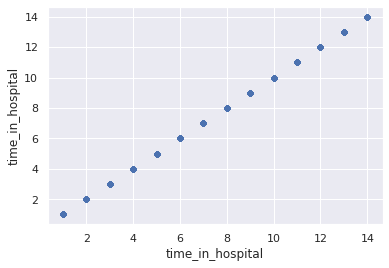

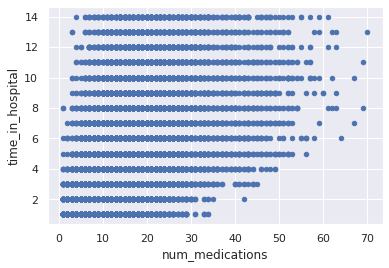

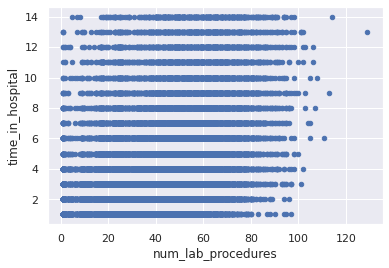

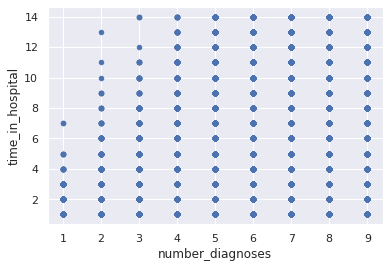

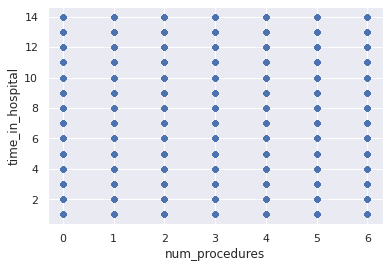

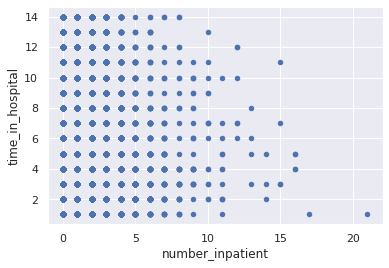

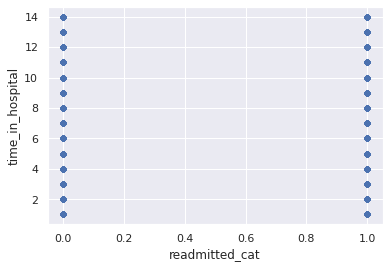

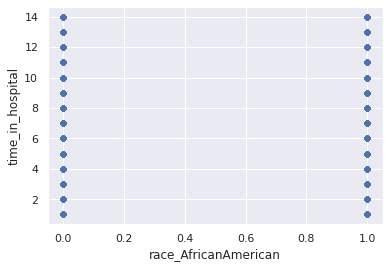

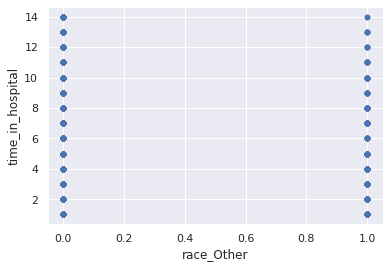

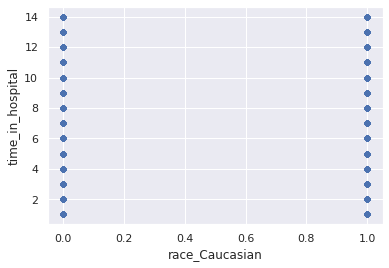

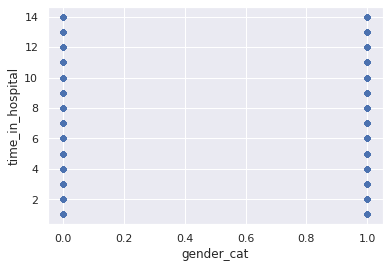

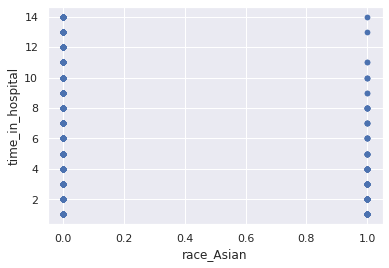

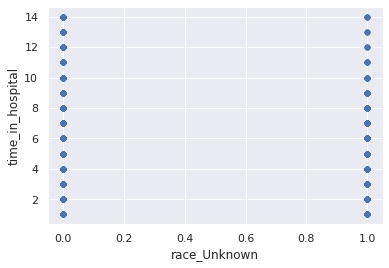

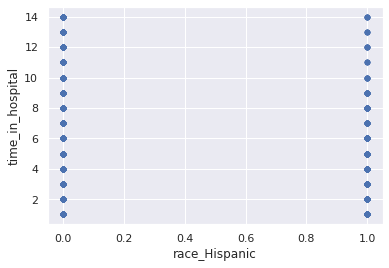

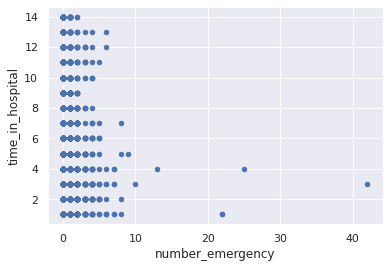

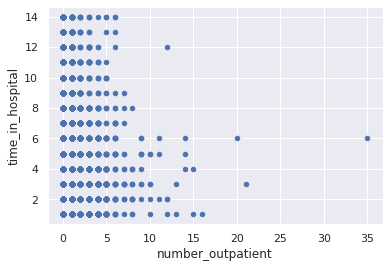

In [45]:
# Por último, deseamos observar de manera gráfica las correlaciones entre 'time_in_hospital' y el resto de variables

for idx in df_numerical_most_corr.index:
    df.plot(kind='scatter',
          x=idx,
          y='time_in_hospital')
    



### determinar qué par de variables están correlacionadas

race        AfricanAmerican  Asian  Caucasian  Hispanic  Other  Unknown
readmitted                                                             
<30         866              17     2698       87        39     81     
>30         2421             46     7772       300       108    199    
NO          3832             103    13399      360       262    652    
Unknown     0                0      0          0         0      1      
race        AfricanAmerican  Asian  Caucasian  Hispanic  Other  Unknown
readmitted                                                             
<30         866              17     2698       87        39     81     
>30         2421             46     7772       300       108    199    
NO          3832             103    13399      360       262    652    
Unknown     0                0      0          0         0      1      


array([<AxesSubplot:ylabel='AfricanAmerican'>,
       <AxesSubplot:ylabel='Asian'>, <AxesSubplot:ylabel='Caucasian'>,
       <AxesSubplot:ylabel='Hispanic'>, <AxesSubplot:ylabel='Other'>,
       <AxesSubplot:ylabel='Unknown'>], dtype=object)

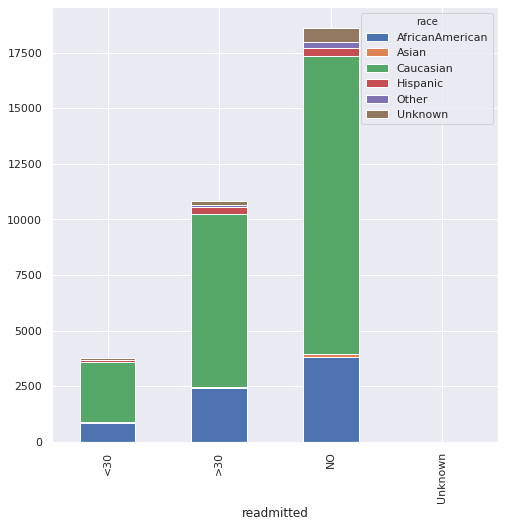

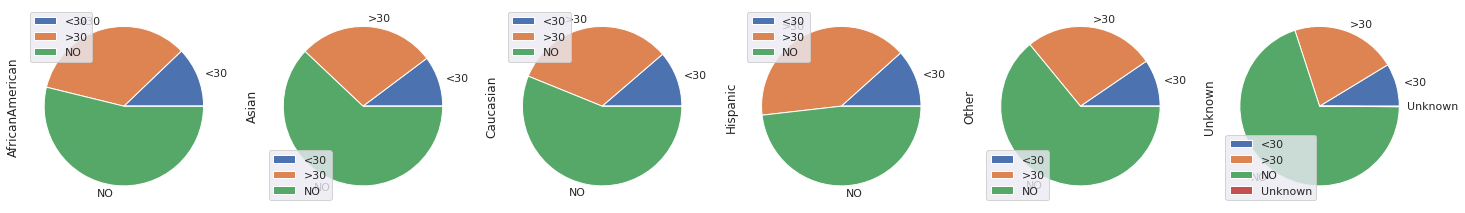

In [46]:
# FUNCION PARA RELACION ENTRE DOS VARIABLES CATEGORICAS

# En este caso, decidimos que la variable 'readmitted' será nuestra variable de salida, por lo que queremos ver de manera gráfica
# cómo se distribuye con respecto a otras variables categóricas, como 'race', 'age', 'gender', 'type_description' y 'weight' 

def relacion_de_columnas (columna_1,columna2):
    my_table = pd.crosstab(index=df[columna_1], 
                          columns=df[columna2])
    
    print(my_table)
    return my_table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

def relacion_de_columnas_pie (columna_1,columna2):
    my_table = pd.crosstab(index=df[columna_1], 
                          columns=df[columna2])
    
    print(my_table)
    
    return my_table.plot(kind="pie", 
                 figsize=(25, 25),
                 stacked=True, subplots=True)

 
# Agrupado Readmitted Race    

relacion_de_columnas("readmitted","race")
relacion_de_columnas_pie("readmitted","race")

In [ ]:
# En este caso, se observa una distribución similar en los 3 casos, si bien el porcentaje de no readmitidos es notablemente mayor
# en la categoría "Other". Asimismo, es menor para la raza de hispanos

readmitted   <30   >30    NO  Unknown
age                                  
[0-10)      3     18    109   0      
[10-20)     20    126   253   0      
[20-30)     79    165   306   0      
[30-40)     170   440   845   0      
[40-50)     398   1181  1956  0      
[50-60)     589   1944  3433  0      
[60-70)     815   2293  3988  1      
[70-80)     1083  3049  4699  0      
[80-90)     570   1451  2571  0      
[90-100)    61    179   448   0      
age         [0-10)  [10-20)  [20-30)  [30-40)  [40-50)  [50-60)  [60-70)  \
readmitted                                                                 
<30         3       20       79       170      398      589      815       
>30         18      126      165      440      1181     1944     2293      
NO          109     253      306      845      1956     3433     3988      
Unknown     0       0        0        0        0        0        1         

age         [70-80)  [80-90)  [90-100)  
readmitted                              
<30  

array([<AxesSubplot:ylabel='[0-10)'>, <AxesSubplot:ylabel='[10-20)'>,
       <AxesSubplot:ylabel='[20-30)'>, <AxesSubplot:ylabel='[30-40)'>,
       <AxesSubplot:ylabel='[40-50)'>, <AxesSubplot:ylabel='[50-60)'>,
       <AxesSubplot:ylabel='[60-70)'>, <AxesSubplot:ylabel='[70-80)'>,
       <AxesSubplot:ylabel='[80-90)'>, <AxesSubplot:ylabel='[90-100)'>],
      dtype=object)

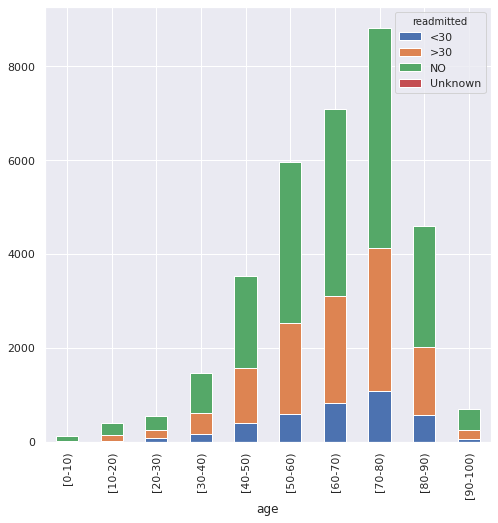

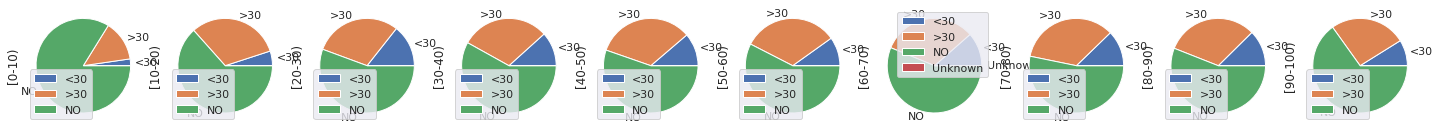

In [47]:
# Agrupado Readmitted age   

relacion_de_columnas("age","readmitted")
relacion_de_columnas_pie("readmitted","age")

In [ ]:
# A nivel edad, de nuevo se observan distribuciones similares entre los distintos rangos

# Las franjas de edad entre [0-10], [10-20] y [30-40] son las que presentan un menos número de readmitidos, siendo similar curiosamente en
# la franja de [60-70]

gender      Female  Male  Unknown/Invalid
readmitted                               
<30         2076    1712  0              
>30         5905    4941  0              
NO          9875    8732  1              
Unknown     0       1     0              
gender      Female  Male  Unknown/Invalid
readmitted                               
<30         2076    1712  0              
>30         5905    4941  0              
NO          9875    8732  1              
Unknown     0       1     0              


array([<AxesSubplot:ylabel='Female'>, <AxesSubplot:ylabel='Male'>,
       <AxesSubplot:ylabel='Unknown/Invalid'>], dtype=object)

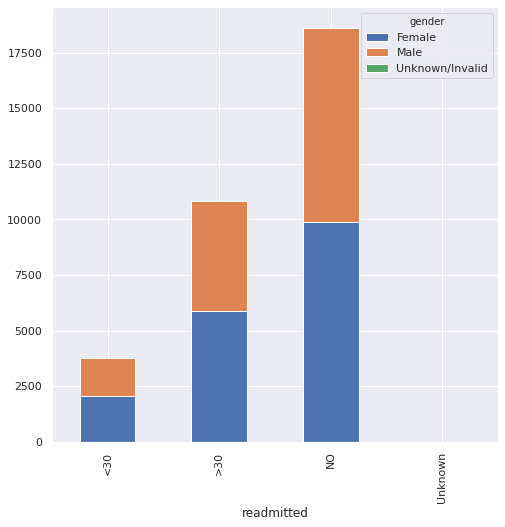

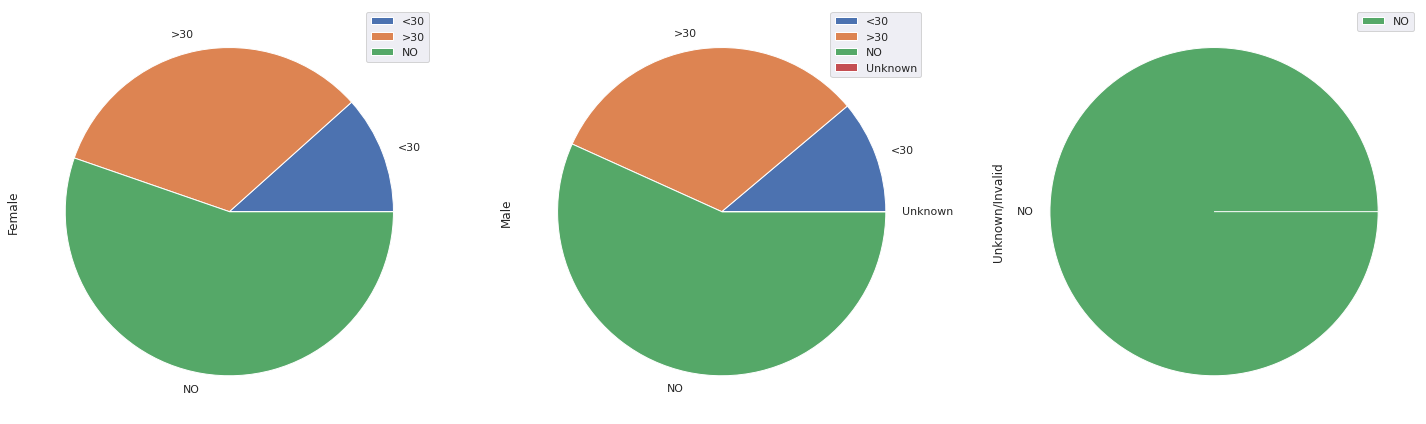

In [48]:
# Agrupado Readmitted gender    

relacion_de_columnas("readmitted","gender")
relacion_de_columnas_pie("readmitted","gender")

In [ ]:
# En el caso del sexo, el porcentaje de mujeres readmitidas es ligeramente mayor que el de hombres

type_description  Elective  Emergency  Newborn  None  Not Available  \
readmitted                                                            
<30               534       1925       1        382   286             
>30               1273      5313       1        1572  886             
NO                3170      8978       2        1397  1466            
Unknown           0         1          0        0     0               

type_description  Not Mapped  Urgent  
readmitted                            
<30               9           651     
>30               14          1787    
NO                32          3563    
Unknown           0           0       
type_description  Elective  Emergency  Newborn  None  Not Available  \
readmitted                                                            
<30               534       1925       1        382   286             
>30               1273      5313       1        1572  886             
NO                3170      8978       2        1397  1

array([<AxesSubplot:ylabel='Elective'>, <AxesSubplot:ylabel='Emergency'>,
       <AxesSubplot:ylabel='Newborn'>, <AxesSubplot:ylabel='None'>,
       <AxesSubplot:ylabel='Not Available'>,
       <AxesSubplot:ylabel='Not Mapped'>, <AxesSubplot:ylabel='Urgent'>],
      dtype=object)

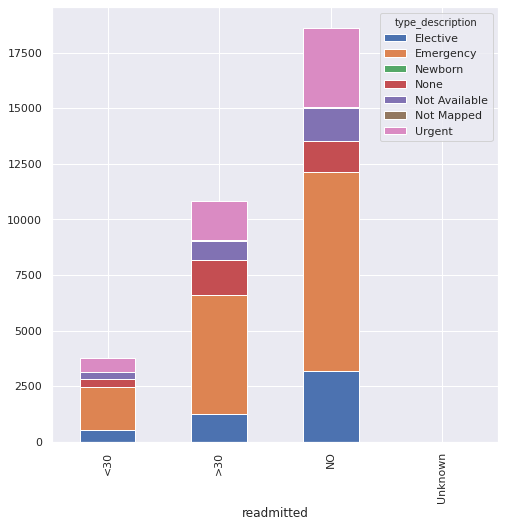

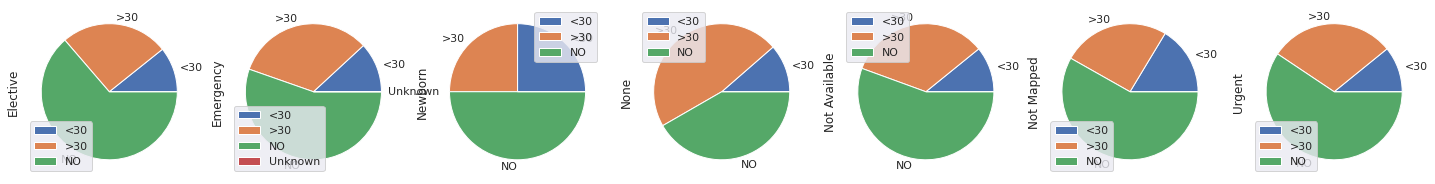

In [49]:
# Agrupado Readmitted type_description   

relacion_de_columnas("readmitted","type_description")
relacion_de_columnas_pie("readmitted","type_description")

In [ ]:
# Aquellos cuya admisión es de tipo "Elective", tienen más posibilidades de no ser ingresados de nuevo, al igual que los de "Urgent"

weight      >200  Unknown  [0-25)  [100-125)  [125-150)  [150-175)  [175-200)  \
readmitted                                                                      
<30         0     3653     6       21         3          2          0           
>30         1     10201    25      112        27         4          1           
NO          0     18216    6       61         21         3          0           
Unknown     0     1        0       0          0          0          0           

weight      [25-50)  [50-75)  [75-100)  
readmitted                              
<30         2        46       55        
>30         14       161      300       
NO          21       125      155       
Unknown     0        0        0         
weight      >200  Unknown  [0-25)  [100-125)  [125-150)  [150-175)  [175-200)  \
readmitted                                                                      
<30         0     3653     6       21         3          2          0           
>30         1     10201 

array([<AxesSubplot:ylabel='>200'>, <AxesSubplot:ylabel='Unknown'>,
       <AxesSubplot:ylabel='[0-25)'>, <AxesSubplot:ylabel='[100-125)'>,
       <AxesSubplot:ylabel='[125-150)'>, <AxesSubplot:ylabel='[150-175)'>,
       <AxesSubplot:ylabel='[175-200)'>, <AxesSubplot:ylabel='[25-50)'>,
       <AxesSubplot:ylabel='[50-75)'>, <AxesSubplot:ylabel='[75-100)'>],
      dtype=object)

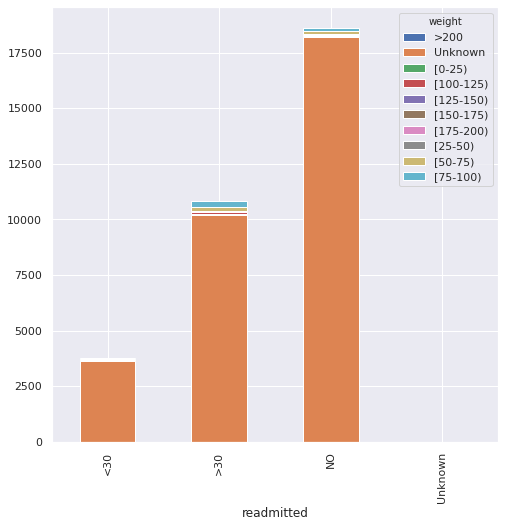

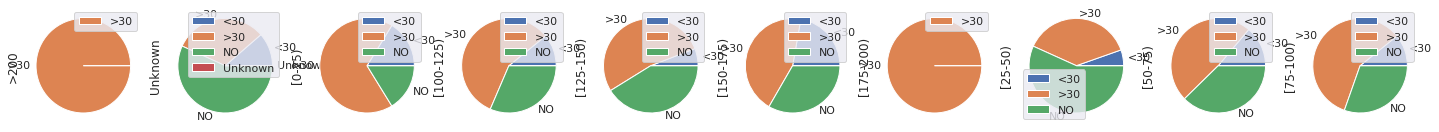

In [50]:
# Agrupado Readmitted weight    

relacion_de_columnas("readmitted","weight")
relacion_de_columnas_pie("readmitted","weight")

In [ ]:
# Dada la distribución de 'weight', es complicado obtener conclusiones a simple vista

# Aquellos que oesan entre 25 y 50 libras, son los que menos han sido reingresados, históricamente hablando



### estudiar los pares de variables correlacionadas para quedarse solamente con una del par

In [ ]:
# CONCUSIONES:
 # En variables numéricas la que tiene mayor correlacion son time_in_hospital versus num_medications o num_procedures
 # en variables categóricas parece más interesante el Readmitted versus raza, edad, tipo de admisión y weight
 # parece que el género no es muy discriminante



# Modelado



### seleccionar variables

In [51]:
# Importación de librerías

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [52]:
# Seleccionamos las variables para un logit de la estancia en el hospital y la probabilidad de ser readmitido y los grupos de población

dfl=df[['race', 'gender', 'age', 'time_in_hospital',  'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'readmitted', 'readmitted_cat', 'readmitted_cat_d']]
dfl.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,readmitted,readmitted_cat,readmitted_cat_d
0,Caucasian,Female,[0-10),1,41,0,1,0,0,0,NO,0,None
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,>30,1,1
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,NO,0,None
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,NO,0,None
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,NO,0,None


array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>],
       [<AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>],
       [<AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

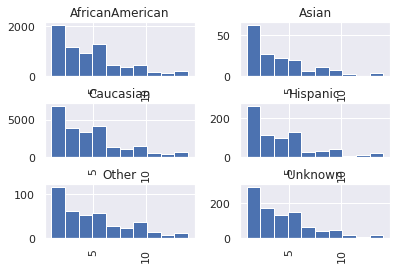

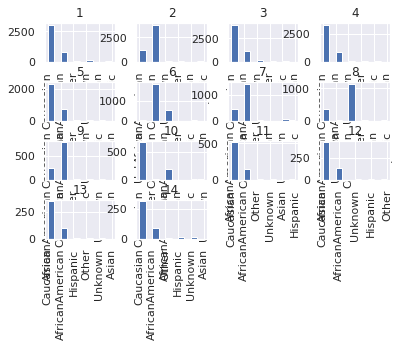

In [53]:
# Exploramos histogramas

df['time_in_hospital'].hist(by=df['race'])
df['race'].hist(by=df['time_in_hospital'])



### estandarizar variables

In [54]:
dfl=df[['race', 'gender', 'age', 'time_in_hospital',  'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'readmitted', 'readmitted_cat', 'readmitted_cat_d']]
dfa = dfl[(dfl['race'] == "AfricanAmerican")]
dfc = dfl[(dfl['race'] == "Caucasian")]
dfh = dfl[(dfl['race'] == "Hispanic")]

dfo = dfl[(dfl['race'] == "Other")]
r=input("Elige el grupo: 1) Todos, 2) AfricanAmerican, 3) Caucasian, 4) Hispanic, 5) Other  ")

Elige el grupo: 1) Todos, 2) AfricanAmerican, 3) Caucasian, 4) Hispanic, 5) Other   Todos


In [55]:
if r == "Todos":
  dfl=dfl
elif r == "AfricanAmerican":
  dfl = dfa
elif r == "Caucasian":
  dfl = dfc
elif r == "Hispanic":
  dfl = dfh
elif r == "Other":
  dfl = dfo

dfl.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,readmitted,readmitted_cat,readmitted_cat_d
0,Caucasian,Female,[0-10),1,41,0,1,0,0,0,NO,0,None
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,>30,1,1
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,NO,0,None
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,NO,0,None
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,NO,0,None


In [56]:
# Estandarizamos las variables explicativas

X = np.array(dfl[['time_in_hospital', 'num_procedures', 'num_medications']])

scaler = preprocessing.StandardScaler()
standardized = scaler.fit_transform(X)
X = standardized
X


array([[-1.16636621, -0.81313337, -1.76392766],
       [-0.52464908, -0.81313337,  0.34655415],
       [-0.84550765,  2.11699199, -0.2741758 ],
       ...,
       [ 0.11706806, -0.81313337, -1.14319772],
       [-0.20379051, -0.81313337, -0.02588382],
       [ 0.11706806, -0.22710829, -0.02588382]])



### lanzar distintos algoritmos



### evaluar los algoritmos para determinar cuál es el que mejor

In [57]:
y = np.array(df['readmitted_cat'])
y

array([0, 1, 0, ..., 1, 0, 0])

In [58]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=1234,
                                                    stratify=y)   # Attention: we pass the "y"

In [59]:
X_train.shape

(24932, 3)

In [60]:
y_train.shape

(24932,)

In [61]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [62]:
prediction = classifier.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [63]:
classifier.predict_proba(X_test).round(2)

array([[0.56, 0.44],
       [0.54, 0.46],
       [0.58, 0.42],
       ...,
       [0.54, 0.46],
       [0.63, 0.37],
       [0.71, 0.29]])

In [64]:
print(prediction[:20])
print(y_test[:20])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
[0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1]


In [65]:
np.mean(prediction == y_test)

0.5638310672602574

In [66]:
classifier.score(X_test, y_test)

0.5638310672602574

In [67]:
classifier.score(X_train, y_train)

0.5607652815658591

In [68]:
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None):
    if eps is None:
        eps = X.std() / 2.
        x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
        y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
        xx = np.linspace(x_min, x_max, 100)
        yy = np.linspace(y_min, y_max, 100)
        X1, X2 = np.meshgrid(xx, yy)
        X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]
    if ax is None:
        ax = plt.gca()
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
        levels=fill_levels, colors=['blue', 'red'])
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
        colors="black")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

In [69]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('Precision:', precision_score(y_test, prediction))
print('Recall:   ', recall_score(y_test, prediction))
print('Fscore:   ', f1_score(y_test, prediction))

Precision: 0.5180851063829788
Recall:    0.1330964744465701
Fscore:    0.21178517068928027


In [70]:
print(classifier.coef_)
print(classifier.intercept_)

# Los coeficientes son de -0.19 para 'time_in_hospital', 0.11 para 'num_procedures' y -0.24 para num_medications

# Esto indica que cuanto más tiempo se pase en el hospital y a mayor número de medicamentos, menos posibilidades de reingresar en un futuro
# Seguramente debido a que a más tiempo, más capacidad de resolver la enfermedad, así como cuantos más medicamentos tomes, menor riesgo de recaída
# Por otro lado, a mayor número de procedimientos, más probabilidades de reingresar.

[[ 0.12468212 -0.19073381  0.11443284]]
[-0.24371371]


In [309]:
#########################################################

In [ ]:
# A continuación, se modelizará con un árbol de decisión, en lugar de una regresión logística, para observar si este tipo de modelo mejora al anterior

In [71]:
# Importamos librerías

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
X = np.array(dfl[['time_in_hospital']])

scaler = preprocessing.StandardScaler()
standardized = scaler.fit_transform(X)
X = standardized
X

array([[-1.16636621],
       [-0.52464908],
       [-0.84550765],
       ...,
       [ 0.11706806],
       [-0.20379051],
       [ 0.11706806]])

In [73]:
y = np.array(df['readmitted_cat'])
y

array([0, 1, 0, ..., 1, 0, 0])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=1234,
                                                    stratify=y)   # Attention: we pass the "y"

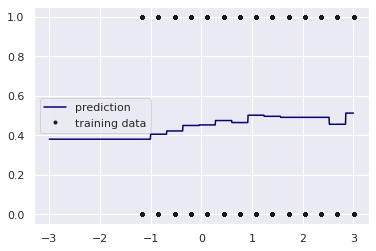

In [75]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=5)
reg.fit(X, y)

X_fit = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_fit_1 = reg.predict(X_fit)

plt.plot(X_fit.ravel(), y_fit_1, color='navy', label="prediction")
plt.plot(X.ravel(), y, '.k', label="training data")
plt.legend(loc="best");

In [76]:
reg.score(X_test, y_test)

0.007486119582255868

In [ ]:
# Claramente, y sin ser un modelo brillante, el modelo de regresión logística ha demostrado ser más valioso que el árbol de decisión a la hora de
# predecir si un paciente va a ser reingresado o no



# EXTRA



### hacer un clustering de aquellos pacientes que por lo menos han sido readmitidos una vez 